# MODEL TRAINING NOTEBOOK - CHALLENGE - PART 2 - BINARY CLASSIFICATION

**Author:** Sushmetha S R – VIT Chennai  
**Team Name:** *expendables*  
**Team Members:** Abhinav Chaitanya R, Arjun M, Harshavardhan S, Kiranchandran H, Sushmetha S R  
**Leaderboard Rank:** 18  


# This is the notebook used for training the model.

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pickle
import json

## Define Paths
Define the file paths for the training dataset.
- `train_dir`: Directory containing training images (all soil).
- `train_csv`: CSV file with training image IDs and labels.

## Load Metadata and Split Data
- Load the training metadata from `train_labels.csv`.
- Split the data into training (80%) and validation (20%) sets to compute a threshold for classification.
- Use a fixed `random_state` for reproducibility.

In [2]:
# Paths
train_dir = "/kaggle/input/soil-classification-part-2/soil_competition-2025/train"
train_csv = "/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv"

# Load metadata
train_ids = pd.read_csv(train_csv)

# Split training data into train and validation sets (80-20 split)
train_ids_subset, val_ids_subset = train_test_split(train_ids, test_size=0.2, random_state=42)
print(f"Training subset: {len(train_ids_subset)} images")
print(f"Validation subset: {len(val_ids_subset)} images")

Training subset: 977 images
Validation subset: 245 images


## Define Image Transformations
Define the preprocessing steps for images to make them compatible with EfficientNet-B0.
- Resize to 224x224 (required by EfficientNet-B0).
- Convert to tensor and normalize using ImageNet statistics.

In [3]:
# Data transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standardize to 224x224 for EfficientNet-B0
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

## Create Dataset Class
The `SoilDataset` class handles loading and preprocessing of images.
- Skips invalid images to ensure robust data loading.
- Returns the transformed image and its ID.

In [4]:
# Dataset Class
class SoilDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform
        self.valid_indices = []
        for idx in range(len(self.df)):
            img_id = self.df.iloc[idx]['image_id']
            img_path = os.path.join(self.data_dir, img_id)
            try:
                with Image.open(img_path) as img:
                    img.convert('RGB')
                self.valid_indices.append(idx)
            except Exception as e:
                print(f"Skipping invalid image {img_path}: {e}")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_id = self.df.iloc[actual_idx]['image_id']
        img_path = os.path.join(self.data_dir, img_id)
        with Image.open(img_path) as img:
            image = img.convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_id

## Create Datasets and DataLoaders
- Create datasets for training and validation sets using `SoilDataset`.
- Use `DataLoader` for batch processing during feature extraction.
- Set `shuffle=False` since we're only extracting features, not training.

In [5]:
# Create datasets and loaders
train_dataset = SoilDataset(train_ids_subset, train_dir, transform=transform)
val_dataset = SoilDataset(val_ids_subset, train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

## Load Pretrained Model
- Load EfficientNet-B0 pretrained on ImageNet.
- Replace the classifier with an identity layer to output 1280-D features (instead of class probabilities).

In [6]:
# Load pretrained EfficientNet-B0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b0(weights='IMAGENET1K_V1')  # Pretrained on ImageNet
model.classifier = nn.Identity()  # Remove classifier to output 1280-D features
model = model.to(device)
model.eval()

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 141MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Load Pretrained Model
- Load EfficientNet-B0 pretrained on ImageNet.
- Replace the classifier with an identity layer to output 1280-D features (instead of class probabilities).

In [7]:
# Extract features
def extract_features(model, loader, desc):
    features = []
    img_ids = []
    with torch.no_grad():
        for imgs, ids in tqdm(loader, desc=desc):
            imgs = imgs.to(device)
            feats = model(imgs)
            features.append(feats.cpu().numpy())
            img_ids.extend(ids)
    return np.concatenate(features, axis=0), img_ids

# Extract features for training and validation sets
train_features, train_img_ids = extract_features(model, train_loader, "Extracting Features (Train)")
val_features, val_img_ids = extract_features(model, val_loader, "Extracting Features (Val)")

Extracting Features (Val): 100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


## Apply PCA
Reduce the dimensionality of features from 1280 to 100 to speed up similarity computation and enable visualization.
- Fit PCA on training features.
- Transform training and validation features.
- Print the explained variance ratio to assess information retention.

In [8]:
# Apply PCA to reduce dimensionality (1280 -> 100)
pca = PCA(n_components=100, random_state=42)
train_features_pca = pca.fit_transform(train_features)
val_features_pca = pca.transform(val_features)
print(f"PCA explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Save PCA model for inference
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

PCA explained variance ratio: 0.8984


## Compute Cosine Similarities
Define a function to compute the average cosine similarity to the top-k training prototypes.
- Input: Test features, training features, and k (number of prototypes).
- Output: Average similarity scores for each image.

## Set Classification Threshold
- Use the validation set (all soil images) to set a threshold for binary classification.
- Set the threshold at the 10th percentile of validation similarities (higher similarity = soil).
- Visualize the similarity distribution to understand the threshold's position.

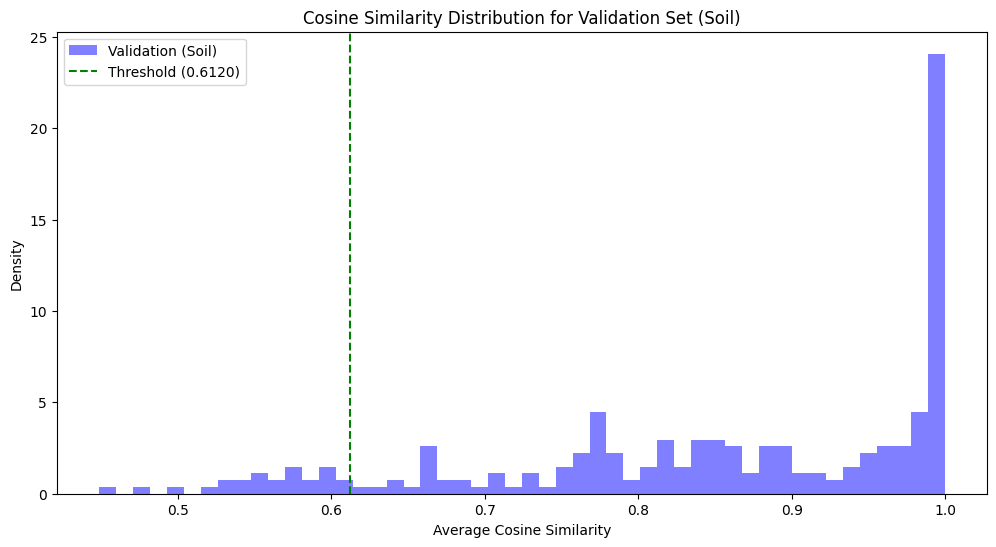

In [9]:
# Compute cosine similarities to training prototypes
def compute_top_k_similarity(test_feats, train_feats, k=5):
    similarities = cosine_similarity(test_feats, train_feats)
    top_k_similarities = np.sort(similarities, axis=1)[:, -k:]
    avg_similarities = np.mean(top_k_similarities, axis=1)
    return avg_similarities

# Compute similarities for validation set
k = 5  # Top-5 prototypes
val_similarities = compute_top_k_similarity(val_features_pca, train_features_pca, k=k)

# Visualize similarity distribution
plt.figure(figsize=(12, 6))
plt.hist(val_similarities, bins=50, color='blue', alpha=0.5, label='Validation (Soil)', density=True)
plt.title('Cosine Similarity Distribution for Validation Set (Soil)')
plt.xlabel('Average Cosine Similarity')
plt.ylabel('Density')
plt.legend()

# Set threshold at 10th percentile of validation similarities
threshold = np.percentile(val_similarities, 10)
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.legend()
plt.show()

## Save and Verify Threshold
- Save the computed threshold (a float) to `threshold.pkl` for use in inference.

In [10]:
# Save threshold for inference (ensure it's a float)
with open('threshold.pkl', 'wb') as f:
    pickle.dump(threshold, f)

# Verify that the saved threshold can be loaded correctly
with open('threshold.pkl', 'rb') as f:
    loaded_threshold = pickle.load(f)
print(f"Loaded threshold (verification): {loaded_threshold:.4f}")  # Should match the computed threshold
if not isinstance(loaded_threshold, (int, float)):
    raise ValueError("Threshold saved in threshold.pkl is not a numeric value!")

Loaded threshold (verification): 0.6120


## Compute Validation Metrics
- Since all validation images are soil (label=1), use the threshold to classify them.
- Compute binary classification metrics: F1-score, precision, recall, and accuracy.

In [11]:
# Compute validation predictions (all training and validation images are soil, label=1)
val_true_labels = [1] * len(val_similarities)  # All validation images are soil
val_preds = [1 if sim >= threshold else 0 for sim in val_similarities]

# Compute evaluation metrics
f1 = f1_score(val_true_labels, val_preds, average='binary', pos_label=1)
precision = precision_score(val_true_labels, val_preds, pos_label=1)
recall = recall_score(val_true_labels, val_preds, pos_label=1)
accuracy = accuracy_score(val_true_labels, val_preds)

print(f"Validation F1-Score: {f1:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation F1-Score: 0.9462
Validation Precision: 1.0000
Validation Recall: 0.8980
Validation Accuracy: 0.8980


## Save Metrics to ml-metrics.json
- Save the computed metrics in a JSON file for submission.

In [12]:
# Save metrics to ml-metrics.json
metrics = {
    "_comment": "This JSON file contains the ML metrics for binary classification",
    "Name": "Sushmetha S R",
    "Kaggle Username": "sushmethasr21bai1162",
    "Team Name": "expendables",
    "metrics": {
        "f1_score_soil": f1,
        "precision_soil": precision,
        "recall_soil": recall,
        "accuracy": accuracy
    }
}
with open('ml-metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to ml-metrics.json")

Saved metrics to ml-metrics.json


## Visualize Dataset Characteristics
Visualize the dataset to understand its properties, focusing on features like color, texture, and patterns.
- **Sample Images**: Display a few training images to show soil characteristics.
- **PCA Feature Distribution**: Plot the first two PCA components to visualize feature separation.
- **RGB Distribution**: Analyze the average RGB values to understand color distribution.

Displaying and saving sample training images:


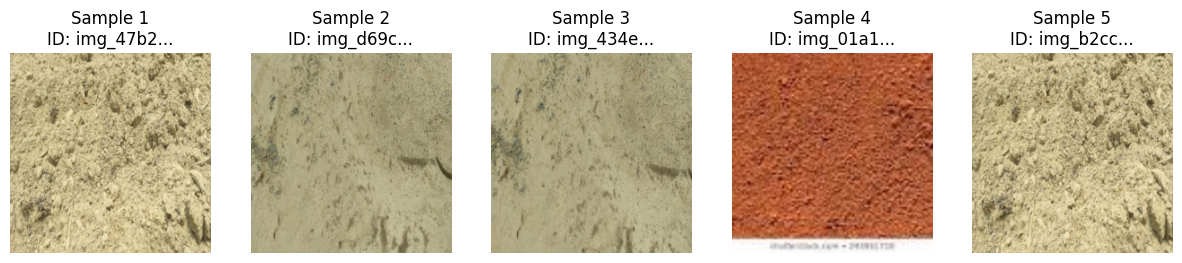

In [13]:
# Display and save sample images from the training set
def display_sample_images(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img, img_id = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Denormalize
        img = np.clip(img, 0, 1)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Sample {i+1}\nID: {img_id[:8]}...")
        plt.axis('off')
    plt.savefig('sample_training_images.png', bbox_inches='tight', dpi=300)  # Save as PNG
    plt.show()

print("Displaying and saving sample training images:")
display_sample_images(train_dataset)

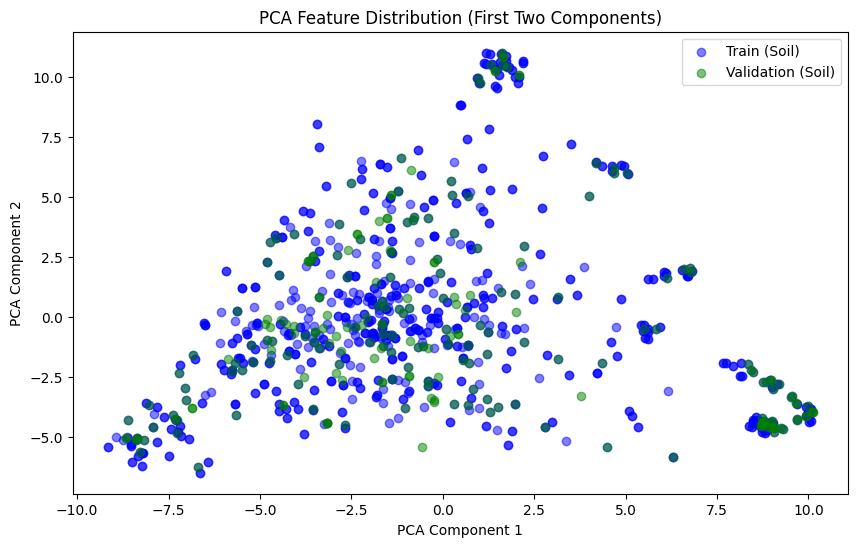

In [14]:
# Visualize and save PCA feature distribution (first two components)
plt.figure(figsize=(10, 6))
plt.scatter(train_features_pca[:, 0], train_features_pca[:, 1], c='blue', alpha=0.5, label='Train (Soil)')
plt.scatter(val_features_pca[:, 0], val_features_pca[:, 1], c='green', alpha=0.5, label='Validation (Soil)')
plt.title('PCA Feature Distribution (First Two Components)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.savefig('pca_feature_distribution.png', bbox_inches='tight', dpi=300)  # Save as PNG
plt.show()

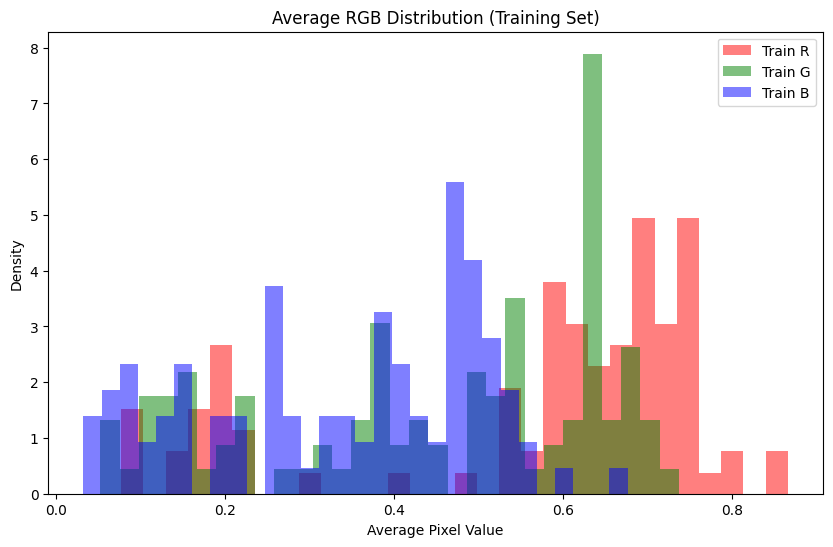

In [15]:
# Visualize and save color distribution (average RGB values of sample images)
def compute_avg_rgb(dataset, num_samples=100):
    r, g, b = [], [], []
    for i in range(min(num_samples, len(dataset))):
        img, _ = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        r.append(img[:, :, 0].mean())
        g.append(img[:, :, 1].mean())
        b.append(img[:, :, 2].mean())
    return np.array(r), np.array(g), np.array(b)

train_r, train_g, train_b = compute_avg_rgb(train_dataset)
val_r, val_g, val_b = compute_avg_rgb(val_dataset)

plt.figure(figsize=(10, 6))
plt.hist(train_r, bins=30, alpha=0.5, color='red', label='Train R', density=True)
plt.hist(train_g, bins=30, alpha=0.5, color='green', label='Train G', density=True)
plt.hist(train_b, bins=30, alpha=0.5, color='blue', label='Train B', density=True)
plt.title('Average RGB Distribution (Training Set)')
plt.xlabel('Average Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.savefig('rgb_distribution_training.png', bbox_inches='tight', dpi=300)  # Save as PNG
plt.show()